In [1]:
import pandas as pd
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import numpy as np
from keras.models import load_model
import time 
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from sklearn.preprocessing import MinMaxScaler

NUM_OF_CLASSES = 3

def prepare_train_test_dataset():
    train_data = pd.read_csv("train_data.csv")
    train_labels = pd.read_csv("train_labels.csv")
    test_data = pd.read_csv("test_data.csv")
    test_labels = pd.read_csv("test_labels.csv")
    whole_data = pd.concat([train_data, test_data])
    min_max_scaler = MinMaxScaler().fit(whole_data)
    train_data = min_max_scaler.transform(train_data)
    test_data = min_max_scaler.transform(test_data)
    train_labels = train_labels.status.astype('category').cat.codes.to_numpy()
    # train_labels = to_categorical(train_labels,NUM_OF_CLASSES)
    test_labels = test_labels.status.astype('category').cat.codes.to_numpy()
    # test_labels = to_categorical(test_labels,NUM_OF_CLASSES)
    return (train_data, train_labels),(test_data, test_labels)

def plot_history(history, epochs_size, file_name):
    loss_list = []
    accuracy_list = []
    history_keys = history.history.keys()
    for key in history_keys:
        if "loss" in key:
            loss_list.append(key)
        
        elif "acc" in key:
            accuracy_list.append(key)
        
        elif "accuracy" in key:
            accuracy_list.append(key)

    # print(loss_list)
    # print(accuracy_list)
    
    colors = list(mcolors.BASE_COLORS.keys())
    epochs = range(1, (epochs_size+1))
    fig, ax = plt.subplots(2, figsize=(20, 8))

    for key,color in zip(loss_list, colors):
        ax[0].plot(epochs ,history.history[key], str(color), label=str(key))

    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("%")
    ax[0].set_title("Loss of Model:")
    ax[0].legend()

    for key,color in zip(accuracy_list, colors):
        ax[1].plot(epochs, history.history[key], str(color), label=str(key))
        
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("%")
    ax[1].set_title("Accuracy of Model:")
    ax[1].legend()

    # set the spacing between subplots
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.8)

    plt.show()

    fig.savefig(file_name + ".pgf", backend="pgf", dpi=1000, bbox_inches="tight")

def append_value(dict_obj, key, value):
    # Check if key exist in dict or not
    if key in dict_obj:
        # Key exist in dict.
        # Check if type of value of key is list or not
        if not isinstance(dict_obj[key], list):
            # If type is not list then make it list
            dict_obj[key] = [dict_obj[key]]
        # Append the value in list
        dict_obj[key].append(value)
    else:
        # As key is not in dict,
        # so, add key-value pair
        dict_obj[key] = value

def print_best_history(history, training_time):
    history_dict = {}
    fnn_history_keys = history.history.keys()
    params_index = np.argmax(history.history["val_acc"])
    for key in fnn_history_keys:
        append_value(history_dict, key, history.history[key][params_index])
    history_dict["training_time"] = training_time
    print(history_dict)
    return history_dict

# Evaluate the model on the test data using `evaluate`
def evaluate_model(model, test_data, test_labels):
    best_fnn = load_model(model.name + ".h5")
    print("Evaluate on test data:")
    test_start = time.time()
    results = best_fnn.evaluate(test_data, test_labels, batch_size=128)
    testing_time = time.time() - test_start
    print("test loss, test acc:", results)
    return results[0], results[1], testing_time

# Compile and Train model
def train_model(model,train_data,train_labels, epochs):
    model_checkpoint_callback_fnn = ModelCheckpoint(
    filepath=(model.name + ".h5"),
    save_weights_only=False,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

    model.compile(optimizer="adam", loss=SparseCategoricalCrossentropy(from_logits=True), metrics=["acc"])

    training_start = time.time()
    model_history = model.fit(train_data, train_labels, epochs=epochs, validation_split=0.1, callbacks=model_checkpoint_callback_fnn)
    training_time = time.time() - training_start
    return model, model_history, training_time

In [4]:
import tensorflow as tf
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [5]:
(train_data, train_labels),(test_data, test_labels) = prepare_train_test_dataset()
# conv_train_data = train_data.to_numpy()
train_data.shape

(77079, 4)

In [6]:
from keras.layers import Dense
from keras.layers import Input
from keras.models import Sequential
from keras.utils.vis_utils import plot_model

EPOCHS = 80

fnn = Sequential([
    Input(shape=(4,), name="input-layer"),
    Dense(64, activation="relu"),
    Dense(128, activation="relu"),
    Dense(256, activation="relu"),
    Dense(128, activation="relu"),
    Dense(16, activation="relu"),
    Dense(3, name="output_layer")
],name="fnn_model")

plot_model(fnn, "fnn_architecture.pdf", show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [10]:
fnn_model, fnn_history, training_time = train_model(fnn, train_data, train_labels, EPOCHS)

Epoch 1/80
2168/2168 [==============================] - 5s 2ms/step - loss: 0.0283 - acc: 0.9891 - val_loss: 0.0222 - val_acc: 0.9930
Epoch 2/80
2168/2168 [==============================] - 4s 2ms/step - loss: 0.0317 - acc: 0.9883 - val_loss: 0.0161 - val_acc: 0.9939
Epoch 3/80
2168/2168 [==============================] - 4s 2ms/step - loss: 0.0396 - acc: 0.9828 - val_loss: 0.0238 - val_acc: 0.9916
Epoch 4/80
2168/2168 [==============================] - 4s 2ms/step - loss: 0.0355 - acc: 0.9870 - val_loss: 0.0173 - val_acc: 0.9926
Epoch 5/80
2168/2168 [==============================] - 4s 2ms/step - loss: 0.0309 - acc: 0.9881 - val_loss: 0.0197 - val_acc: 0.9929
Epoch 6/80
2168/2168 [==============================] - 4s 2ms/step - loss: 0.0325 - acc: 0.9880 - val_loss: 0.0231 - val_acc: 0.9920
Epoch 7/80
2168/2168 [==============================] - 4s 2ms/step - loss: 0.0326 - acc: 0.9883 - val_loss: 0.0178 - val_acc: 0.9926
Epoch 8/80
2168/2168 [==============================] - 4s 2ms

{'loss': 0.01949240267276764, 'acc': 0.9923743605613708, 'val_loss': 0.011015242896974087, 'val_acc': 0.9962376952171326, 'training_time': 329.52949237823486}


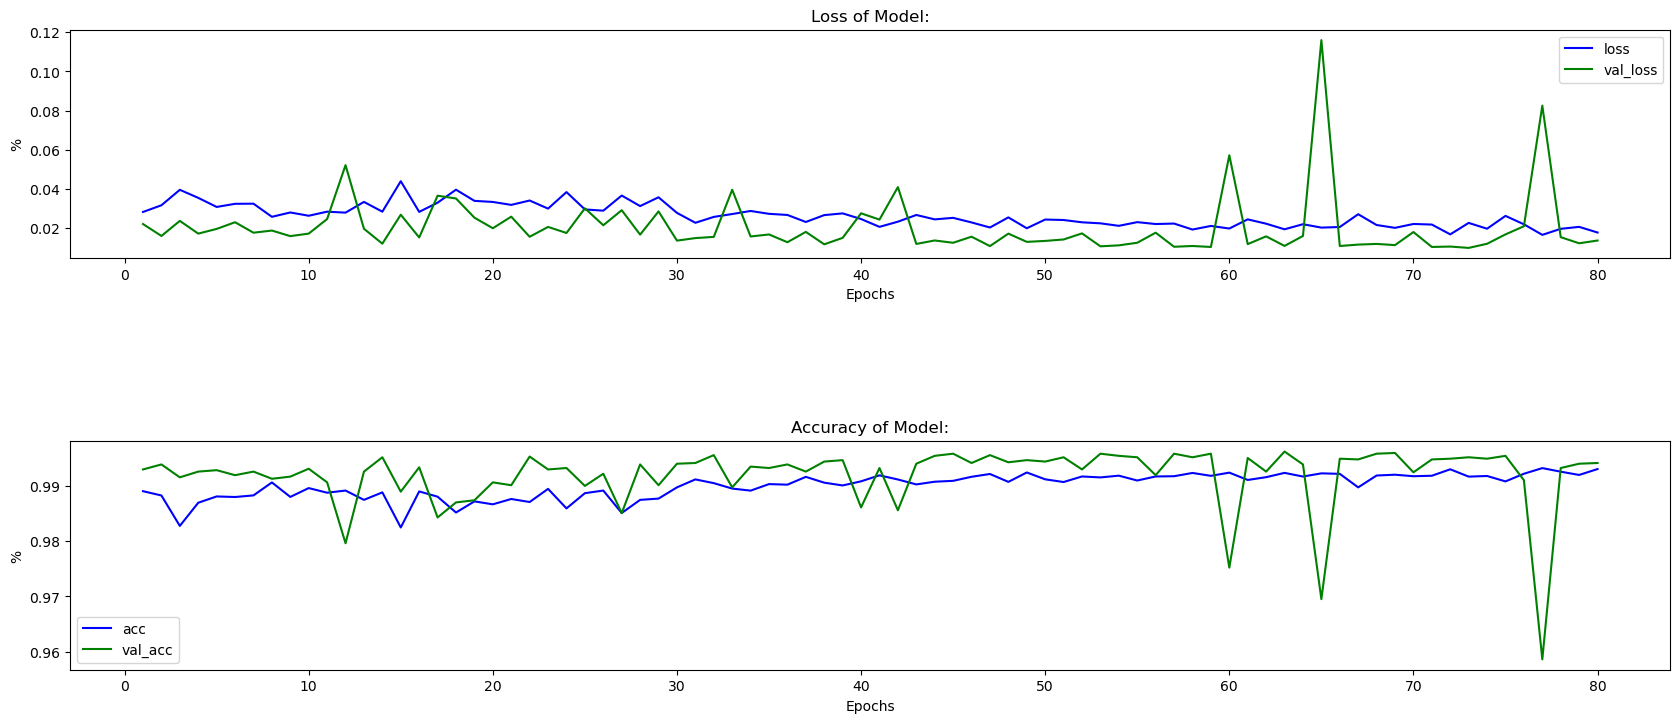

In [11]:
history_dict = print_best_history(fnn_history, training_time)
plot_history(history=fnn_history, epochs_size=EPOCHS, file_name="history_fnn")

In [12]:
loss, accuracy, testing_time = evaluate_model(model=fnn_model, test_data=test_data, test_labels=test_labels)
print("Time for testing: " + str(testing_time))

Evaluate on test data:
151/151 [==============================] - 0s 1ms/step - loss: 0.0551 - acc: 0.9947
test loss, test acc: [0.05506516247987747, 0.9946548938751221]
Time for testing: 0.3923802375793457


In [17]:
from keras import Sequential 
from keras.layers import Conv1D, Dense, Flatten, Input
from keras.utils.vis_utils import plot_model
conv_fnn = Sequential([
    Input(shape=(4,1), name="input-layer"),
    Conv1D(filters=9, kernel_size=2, activation="relu"),
    Dense(32, activation="relu"),
    Dense(32, activation="relu"),
    Dense(16,activation="relu"),
    Flatten(),
    Dense(3)
], name="conv_fnn_model")
plot_model(conv_fnn, "conv_fnn_architecture.pdf", show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [18]:
# conv_train_data = train_data.reshape(77079,4,1)

conv_fnn_model, conv_fnn_history, training_time = train_model(conv_fnn, train_data, train_labels, EPOCHS)

Epoch 1/80
2168/2168 [==============================] - 8s 3ms/step - loss: 0.5752 - acc: 0.7801 - val_loss: 0.3034 - val_acc: 0.8952
Epoch 2/80
2168/2168 [==============================] - 7s 3ms/step - loss: 0.2836 - acc: 0.8930 - val_loss: 0.2453 - val_acc: 0.9127
Epoch 3/80
2168/2168 [==============================] - 5s 2ms/step - loss: 0.2498 - acc: 0.9045 - val_loss: 0.2451 - val_acc: 0.9120
Epoch 4/80
2168/2168 [==============================] - 8s 4ms/step - loss: 0.2388 - acc: 0.9088 - val_loss: 0.2574 - val_acc: 0.9104
Epoch 5/80
2168/2168 [==============================] - 7s 3ms/step - loss: 0.2293 - acc: 0.9124 - val_loss: 0.2205 - val_acc: 0.9031
Epoch 6/80
2168/2168 [==============================] - 9s 4ms/step - loss: 0.2208 - acc: 0.9154 - val_loss: 0.1988 - val_acc: 0.9127
Epoch 7/80
2168/2168 [==============================] - 5s 2ms/step - loss: 0.2130 - acc: 0.9176 - val_loss: 0.2003 - val_acc: 0.9189
Epoch 8/80
2168/2168 [==============================] - 7s 3ms

{'loss': 0.06303545087575912, 'acc': 0.9776419401168823, 'val_loss': 0.04703735560178757, 'val_acc': 0.9852101802825928, 'training_time': 621.5931968688965}


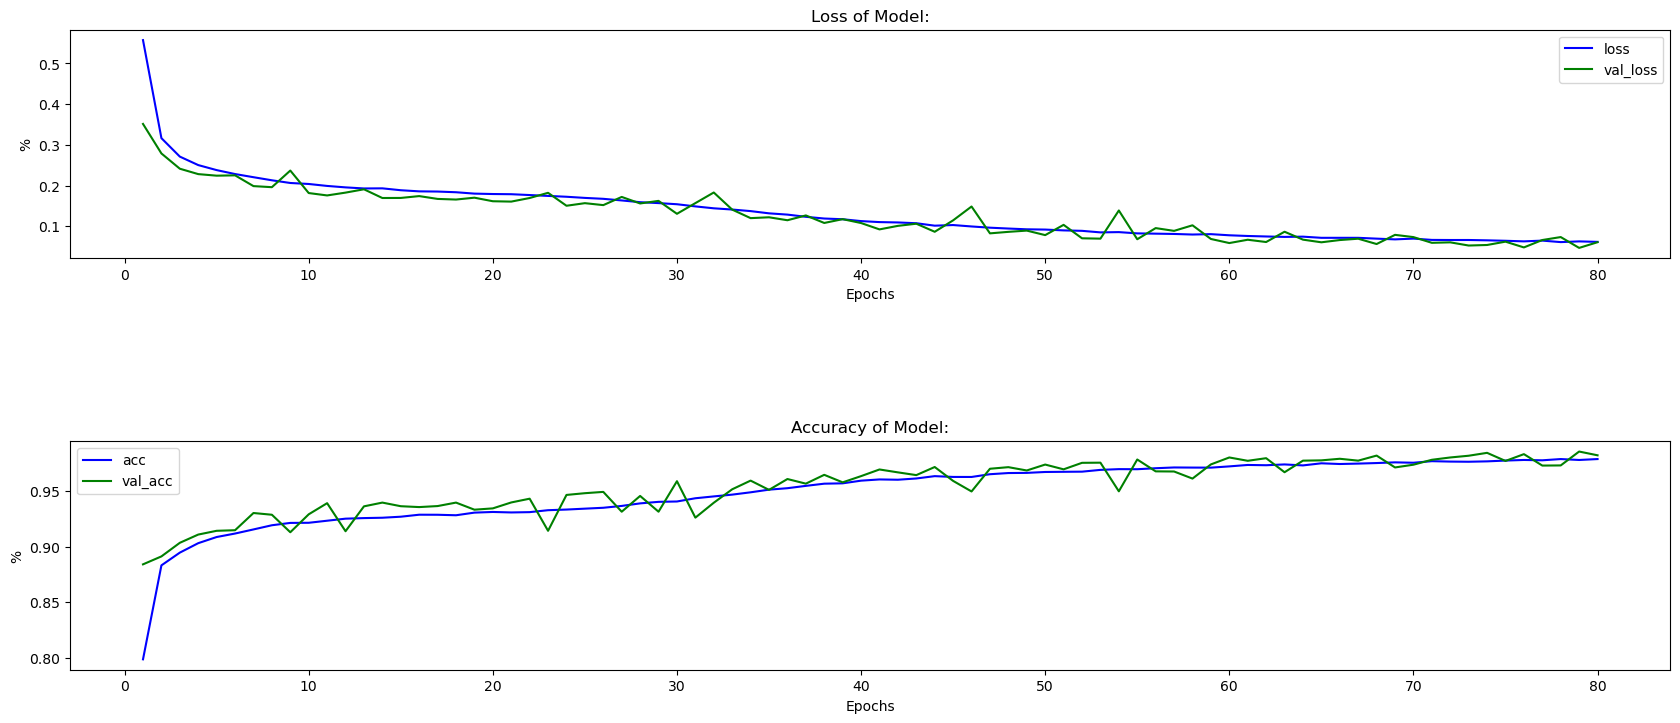

In [15]:
history_dict = print_best_history(conv_fnn_history, training_time)
plot_history(history=conv_fnn_history, epochs_size=EPOCHS, file_name="history_conv_fnn")

In [16]:
loss, accuracy, testing_time = evaluate_model(model=conv_fnn_model, test_data=test_data, test_labels=test_labels)
print("Time for testing: " + str(testing_time))

Evaluate on test data:
151/151 [==============================] - 0s 1ms/step - loss: 0.0538 - acc: 0.9817
test loss, test acc: [0.05378761887550354, 0.9817332625389099]
Time for testing: 0.45863795280456543


# Result: FNN is the winnner! 